# Why Refractive Calibration Matters

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tlancaster6/AquaCal/blob/main/docs/tutorials/02_synthetic_validation.ipynb)

Underwater imaging systems view targets through a flat air-water interface. A standard
pinhole camera model ignores refraction at this interface, treating light as travelling
in a straight line from camera to target. AquaCal corrects this using Snell's law.

**But does it actually matter?** This tutorial answers that question with three
controlled synthetic experiments:

1. **Parameter Fidelity** — Can both models fit the data? Which one recovers correct parameters?
2. **Depth Generalization** — When we calibrate at one depth and measure at another, how do the models compare?
3. **Depth Scaling** — Even if we calibrate at the same depth we measure, does the non-refractive error grow with depth?

Because we control all ground truth parameters, we can measure exactly where each
model fails and why.

In [1]:
# Toggle rig size:
#   "small" — 4 cameras, 20 frames, ideal conditions. Fast, ~2 min total.
#   "large" — 13 cameras, 30 frames, realistic noise. Compelling results, ~60 min total.
RIG_SIZE = "small"

## Setup and Imports

In [2]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# Make sure project root is on path (needed when running as a notebook)
_project_root = Path().resolve()
while _project_root.name and not (_project_root / "src").exists():
    _project_root = _project_root.parent
if str(_project_root) not in sys.path:
    sys.path.insert(0, str(_project_root))

from aquacal.config.schema import BoardConfig, InterfaceParams
from aquacal.core.board import BoardGeometry
from tests.synthetic.experiment_helpers import (
    calibrate_synthetic,
    compute_per_camera_errors,
    evaluate_reconstruction,
)
from tests.synthetic.ground_truth import (
    SyntheticScenario,
    create_scenario,
    generate_dense_xy_grid,
    generate_real_rig_array,
    generate_real_rig_trajectory,
    generate_synthetic_detections,
)

# Consistent color palette for all plots
COLOR_REFRACTIVE = "#2196F3"      # Blue
COLOR_NON_REFRACTIVE = "#F44336"  # Red
LABEL_REFRACTIVE = "Refractive (AquaCal)"
LABEL_NON_REFRACTIVE = "Non-refractive (pinhole)"

print("Imports complete.")

Imports complete.


## Preset Configuration

The `"small"` preset uses the `"ideal"` scenario: 4 cameras arranged in a grid,
near the water surface (15 cm above), boards at 0.25–0.45 m depth, no noise.
This is fast and lets you verify the math.

The `"large"` preset uses the `"realistic"` scenario: 13 cameras matching real
hardware (center + two concentric rings), 0.75 m above water, boards at 0.9–1.5 m
depth, 0.5 px noise. This produces compelling quantitative results.

In [3]:
if RIG_SIZE == "small":
    # create_scenario("ideal"): 4 cameras at Z=0, water at Z=0.15, boards at Z=0.25-0.45m
    # All test/sweep depths must be > 0.15m (below water surface)
    SCENARIO_NAME = "ideal"
    # Exp2: calibrate on narrow band, test at these depths (all underwater)
    EXP2_CALIB_RANGE = (0.30, 0.40)
    EXP2_TEST_DEPTHS = [0.22, 0.28, 0.35, 0.42, 0.50]
    EXP2_N_CALIB_FRAMES = 15
    # Exp3: calibrate at each depth, evaluate at same depth
    EXP3_SWEEP_DEPTHS = [0.22, 0.30, 0.40, 0.50]
    EXP3_N_CALIB_FRAMES = 15
else:
    # create_scenario("realistic"): 13 cameras, water at ~0.75m, boards at 0.9-1.5m depth
    SCENARIO_NAME = "realistic"
    # Exp2: calibrate on narrow band, test across a wide depth range
    EXP2_CALIB_RANGE = (0.95, 1.05)
    EXP2_TEST_DEPTHS = [0.80, 0.90, 1.00, 1.10, 1.20, 1.40, 1.70, 2.00]
    EXP2_N_CALIB_FRAMES = 50
    # Exp3: calibrate at each depth, evaluate at same depth
    EXP3_SWEEP_DEPTHS = [0.85, 1.0, 1.2, 1.5, 2.0, 2.5]
    EXP3_N_CALIB_FRAMES = 30

print(f"RIG_SIZE = {RIG_SIZE!r}")
print(f"  Scenario:            {SCENARIO_NAME}")
print(f"  Exp2 calib range:    {EXP2_CALIB_RANGE}")
print(f"  Exp2 test depths:    {EXP2_TEST_DEPTHS}")
print(f"  Exp3 sweep depths:   {EXP3_SWEEP_DEPTHS}")


RIG_SIZE = 'small'
  Scenario:            ideal
  Exp2 calib range:    (0.3, 0.4)
  Exp2 test depths:    [0.22, 0.28, 0.35, 0.42, 0.5]
  Exp3 sweep depths:   [0.22, 0.3, 0.4, 0.5]


---
## Experiment 1: Parameter Fidelity

**Question:** When we calibrate both models on identical data, do they recover
the correct camera parameters?

We generate a synthetic scenario with known ground truth, then run the full
calibration pipeline twice — once with the refractive model (n_water = 1.333)
and once with the non-refractive pinhole approximation (n_water = 1.0). Both
optimizations minimize reprojection error on the same 2D observations.

The key insight: **a model can fit 2D observations without learning correct 3D geometry**.
If the model is wrong, it will compensate by adjusting focal length and camera positions.

In [4]:
print("=== Experiment 1: Parameter Fidelity ===")
scenario = create_scenario(SCENARIO_NAME, seed=42)
print(f"Scenario: {scenario.description}")
print(f"  Cameras: {len(scenario.intrinsics)}")
print(f"  Frames:  {len(scenario.board_poses)}")
print(f"  Noise:   {scenario.noise_std} px")

print("\nCalibrating refractive model (n_water=1.333)...")
result_refr, _ = calibrate_synthetic(scenario, n_water=1.333, refine_intrinsics=True)
errors_refr = compute_per_camera_errors(result_refr, scenario)
print(f"  Reprojection RMS: {result_refr.diagnostics.reprojection_error_rms:.4f} px")

print("\nCalibrating non-refractive model (n_water=1.0)...")
result_nonrefr, _ = calibrate_synthetic(scenario, n_water=1.0, refine_intrinsics=True)
errors_nonrefr = compute_per_camera_errors(result_nonrefr, scenario)
print(f"  Reprojection RMS: {result_nonrefr.diagnostics.reprojection_error_rms:.4f} px")

print("\nBoth calibrations complete.")
print(f"  Note: similar reprojection errors ({result_refr.diagnostics.reprojection_error_rms:.3f} vs "
      f"{result_nonrefr.diagnostics.reprojection_error_rms:.3f} px) — "
      "look at parameter errors next.")

=== Experiment 1: Parameter Fidelity ===
Scenario: Ideal conditions: 4 cameras, 20 frames, 0 noise
  Cameras: 4
  Frames:  20
  Noise:   0.0 px

Calibrating refractive model (n_water=1.333)...


Stage 2: Extrinsic initialization...
Stage 3: Joint refractive optimization...


Stage 4: Intrinsic refinement...


  Reprojection RMS: 0.0000 px

Calibrating non-refractive model (n_water=1.0)...


Stage 2: Extrinsic initialization...
Stage 3: Joint refractive optimization...


Stage 4: Intrinsic refinement...


  Reprojection RMS: 3.0480 px

Both calibrations complete.
  Note: similar reprojection errors (0.000 vs 3.048 px) — look at parameter errors next.


### Focal Length Recovery

When refraction bends rays at the interface, a non-refractive model compensates by
adjusting focal length. The result: a systematically biased focal length that happens
to minimize 2D reprojection error but does not match the true optics.

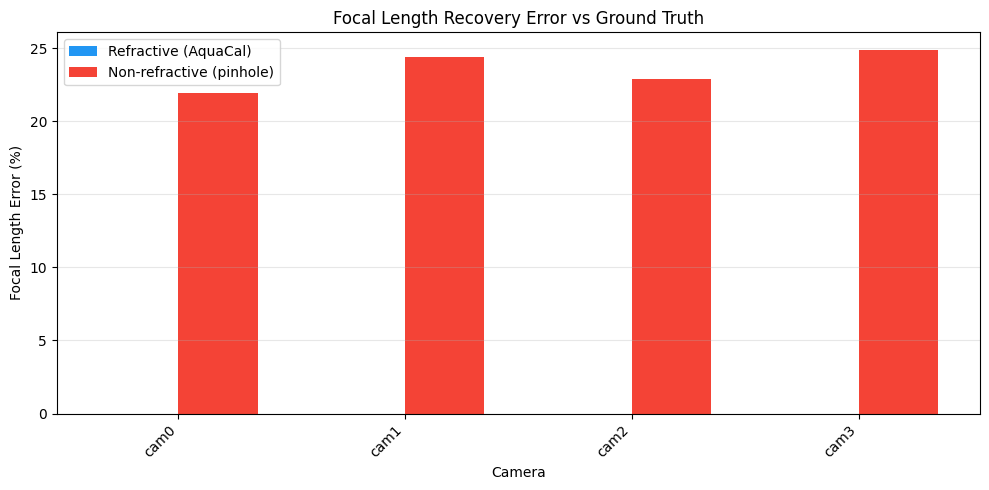

Mean absolute focal length error:
  Refractive:     0.000%
  Non-refractive: 23.522%


In [5]:
camera_names = sorted(scenario.intrinsics.keys())
x = np.arange(len(camera_names))
width = 0.35

focal_refr = [errors_refr[cam]["focal_length_error_pct"] for cam in camera_names]
focal_nonrefr = [errors_nonrefr[cam]["focal_length_error_pct"] for cam in camera_names]

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width / 2, focal_refr, width, label=LABEL_REFRACTIVE, color=COLOR_REFRACTIVE)
ax.bar(x + width / 2, focal_nonrefr, width, label=LABEL_NON_REFRACTIVE, color=COLOR_NON_REFRACTIVE)
ax.set_xlabel("Camera")
ax.set_ylabel("Focal Length Error (%)")
ax.set_title("Focal Length Recovery Error vs Ground Truth")
ax.set_xticks(x)
ax.set_xticklabels(camera_names, rotation=45, ha="right")
ax.axhline(0, color="black", linewidth=0.5, linestyle="--")
ax.legend()
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

mean_focal_refr = np.mean([abs(e) for e in focal_refr])
mean_focal_nonrefr = np.mean([abs(e) for e in focal_nonrefr])
print(f"Mean absolute focal length error:")
print(f"  Refractive:     {mean_focal_refr:.3f}%")
print(f"  Non-refractive: {mean_focal_nonrefr:.3f}%")

### Camera Z Position Recovery

Along with focal length, the non-refractive model misplaces camera positions along
the Z axis (depth). These two biases together produce a model that fits 2D projections
but triangulates 3D positions incorrectly.

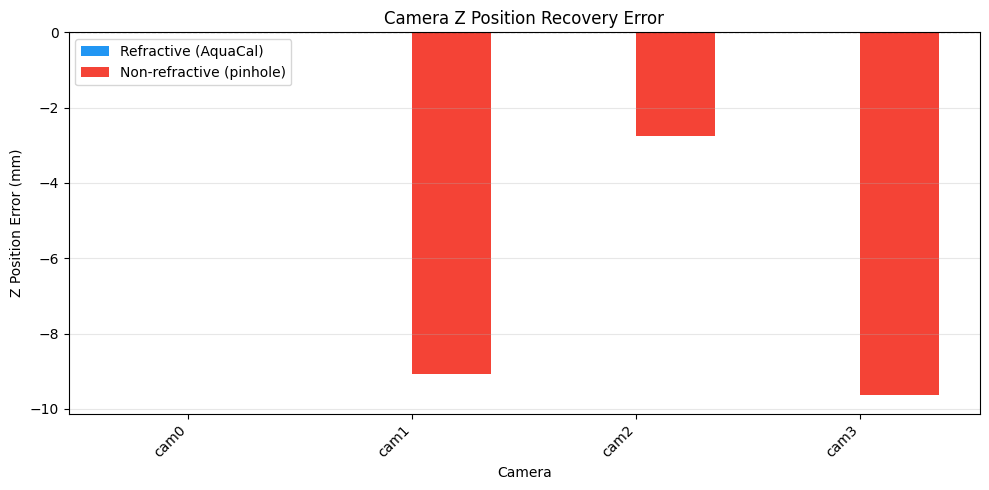

Mean absolute Z position error:
  Refractive:     0.00 mm
  Non-refractive: 5.36 mm


In [6]:
z_refr = [errors_refr[cam]["z_position_error_mm"] for cam in camera_names]
z_nonrefr = [errors_nonrefr[cam]["z_position_error_mm"] for cam in camera_names]

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width / 2, z_refr, width, label=LABEL_REFRACTIVE, color=COLOR_REFRACTIVE)
ax.bar(x + width / 2, z_nonrefr, width, label=LABEL_NON_REFRACTIVE, color=COLOR_NON_REFRACTIVE)
ax.set_xlabel("Camera")
ax.set_ylabel("Z Position Error (mm)")
ax.set_title("Camera Z Position Recovery Error")
ax.set_xticks(x)
ax.set_xticklabels(camera_names, rotation=45, ha="right")
ax.axhline(0, color="black", linewidth=0.8, linestyle="--")
ax.legend()
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

mean_z_refr = np.mean([abs(e) for e in z_refr])
mean_z_nonrefr = np.mean([abs(e) for e in z_nonrefr])
print(f"Mean absolute Z position error:")
print(f"  Refractive:     {mean_z_refr:.2f} mm")
print(f"  Non-refractive: {mean_z_nonrefr:.2f} mm")

### Camera XY Position Recovery

Top-down view of camera positions. Arrows show how far each estimated position
is from ground truth. A good calibration produces very short arrows.

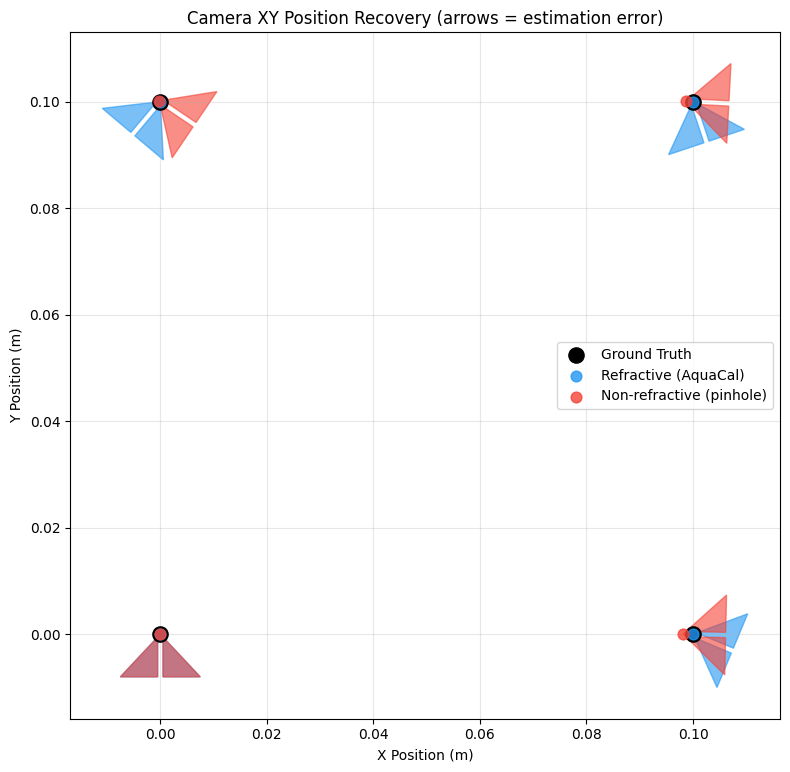

Mean XY position error:
  Refractive:     0.00 mm
  Non-refractive: 0.85 mm


In [7]:
fig, ax = plt.subplots(figsize=(8, 8))

for i, cam_name in enumerate(camera_names):
    C_gt = scenario.extrinsics[cam_name].C
    C_refr = result_refr.cameras[cam_name].extrinsics.C
    C_nonrefr = result_nonrefr.cameras[cam_name].extrinsics.C

    gt_label = "Ground Truth" if i == 0 else None
    refr_label = LABEL_REFRACTIVE if i == 0 else None
    nonrefr_label = LABEL_NON_REFRACTIVE if i == 0 else None

    ax.scatter(C_gt[0], C_gt[1], color="black", s=120, zorder=3, label=gt_label, marker="o")
    ax.scatter(C_refr[0], C_refr[1], color=COLOR_REFRACTIVE, s=60, zorder=4, label=refr_label, alpha=0.8)
    ax.scatter(C_nonrefr[0], C_nonrefr[1], color=COLOR_NON_REFRACTIVE, s=60, zorder=4, label=nonrefr_label, alpha=0.8)

    dx_refr = C_refr[0] - C_gt[0]
    dy_refr = C_refr[1] - C_gt[1]
    dx_nonrefr = C_nonrefr[0] - C_gt[0]
    dy_nonrefr = C_nonrefr[1] - C_gt[1]

    arrow_kw = dict(head_width=0.015, head_length=0.008, length_includes_head=True)
    ax.arrow(C_gt[0], C_gt[1], dx_refr, dy_refr, color=COLOR_REFRACTIVE, alpha=0.6, **arrow_kw)
    ax.arrow(C_gt[0], C_gt[1], dx_nonrefr, dy_nonrefr, color=COLOR_NON_REFRACTIVE, alpha=0.6, **arrow_kw)

ax.set_xlabel("X Position (m)")
ax.set_ylabel("Y Position (m)")
ax.set_title("Camera XY Position Recovery (arrows = estimation error)")
ax.set_aspect("equal")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

mean_xy_refr = np.mean([errors_refr[cam]["xy_position_error_mm"] for cam in camera_names])
mean_xy_nonrefr = np.mean([errors_nonrefr[cam]["xy_position_error_mm"] for cam in camera_names])
print(f"Mean XY position error:")
print(f"  Refractive:     {mean_xy_refr:.2f} mm")
print(f"  Non-refractive: {mean_xy_nonrefr:.2f} mm")

### Experiment 1 Takeaway

Both models achieve similar reprojection error — the 2D fitting quality looks the same.
But the non-refractive model absorbs the refraction effect into systematically biased
focal lengths and camera positions. The refractive model recovers the true physical
parameters.

**Why it matters:** Biased parameters produce systematic 3D reconstruction errors
that grow with depth — exactly what Experiment 2 will show.

---
## Experiment 2: Depth Generalization

**Question:** When we calibrate at one depth range and measure at another depth,
which model generalizes better?

Real underwater surveys rarely stay at exactly the calibration depth. Fish tracking
systems follow animals at varying depths; coral surveys cover different depth strata.

We calibrate both models on a narrow depth band, then evaluate 3D reconstruction
accuracy at a range of test depths — both inside and outside the calibration zone.
The refractive model should generalize because it learned the correct geometry;
the non-refractive model's bias is depth-dependent.

In [8]:
print("=== Experiment 2: Depth Generalization ===")
print(f"Calibration depth range: {EXP2_CALIB_RANGE}")
print(f"Test depths: {EXP2_TEST_DEPTHS}")

# Build rig from the preset scenario's parameters
# For the small preset: use the ideal scenario's rig geometry
# For the large preset: use the realistic 13-camera rig
if RIG_SIZE == "small":
    from tests.synthetic.ground_truth import create_scenario as _cs
    _base = _cs("ideal", seed=42)
    intrinsics_exp2 = _base.intrinsics
    extrinsics_exp2 = _base.extrinsics
    water_zs_exp2 = _base.water_zs
    board_config_exp2 = _base.board_config
    noise_std_exp2 = 0.0
    n_grid_exp2 = 4  # smaller grid for 4-camera rig
    xy_extent_exp2 = 0.05
    tilt_deg_exp2 = 2.0
else:
    intrinsics_exp2, extrinsics_exp2, water_zs_exp2 = generate_real_rig_array(
        height_above_water=0.75, height_variation=0.002, seed=42
    )
    board_config_exp2 = BoardConfig(
        squares_x=12, squares_y=9,
        square_size=0.060, marker_size=0.045,
        dictionary="DICT_5X5_100",
    )
    noise_std_exp2 = 0.5
    n_grid_exp2 = 7
    xy_extent_exp2 = 0.5
    tilt_deg_exp2 = 3.0

board_exp2 = BoardGeometry(board_config_exp2)

# Build calibration scenario on narrow depth band
if RIG_SIZE == "small":
    from aquacal.datasets.synthetic import generate_board_trajectory
    camera_positions_exp2 = {cam: ext.C for cam, ext in extrinsics_exp2.items()}
    calib_poses_exp2 = generate_board_trajectory(
        n_frames=EXP2_N_CALIB_FRAMES,
        camera_positions=camera_positions_exp2,
        water_zs=water_zs_exp2,
        depth_range=EXP2_CALIB_RANGE,
        xy_extent=xy_extent_exp2,
        seed=42,
    )
else:
    calib_poses_exp2 = generate_real_rig_trajectory(
        n_frames=EXP2_N_CALIB_FRAMES,
        depth_range=EXP2_CALIB_RANGE,
        seed=42,
    )

calib_scenario_exp2 = SyntheticScenario(
    name="exp2_calib",
    board_config=board_config_exp2,
    intrinsics=intrinsics_exp2,
    extrinsics=extrinsics_exp2,
    water_zs=water_zs_exp2,
    board_poses=calib_poses_exp2,
    noise_std=noise_std_exp2,
    description=f"Calibration at {EXP2_CALIB_RANGE}",
)

print("Calibrating refractive model...")
result_refr_exp2, _ = calibrate_synthetic(calib_scenario_exp2, n_water=1.333, refine_intrinsics=True)
print(f"  RMS: {result_refr_exp2.diagnostics.reprojection_error_rms:.4f} px")

print("Calibrating non-refractive model...")
result_nonrefr_exp2, _ = calibrate_synthetic(calib_scenario_exp2, n_water=1.0, refine_intrinsics=True)
print(f"  RMS: {result_nonrefr_exp2.diagnostics.reprojection_error_rms:.4f} px")

print("\nBoth calibrations complete. Evaluating at test depths...")

=== Experiment 2: Depth Generalization ===
Calibration depth range: (0.3, 0.4)
Test depths: [0.22, 0.28, 0.35, 0.42, 0.5]
Calibrating refractive model...


Stage 2: Extrinsic initialization...


Stage 3: Joint refractive optimization...


Stage 4: Intrinsic refinement...


  RMS: 0.0000 px
Calibrating non-refractive model...
Stage 2: Extrinsic initialization...


Stage 3: Joint refractive optimization...


Stage 4: Intrinsic refinement...


  RMS: 2.9393 px

Both calibrations complete. Evaluating at test depths...


In [9]:
results_refr_exp2 = []
results_nonrefr_exp2 = []

for depth in EXP2_TEST_DEPTHS:
    print(f"  Evaluating Z = {depth:.2f} m...")

    test_poses = generate_dense_xy_grid(
        depth=depth,
        n_grid=n_grid_exp2,
        xy_extent=xy_extent_exp2,
        tilt_deg=tilt_deg_exp2,
        frame_offset=1000,
        seed=42 + int(depth * 100),
    )

    test_detections = generate_synthetic_detections(
        intrinsics=intrinsics_exp2,
        extrinsics=extrinsics_exp2,
        water_zs=water_zs_exp2,
        board=board_exp2,
        board_poses=test_poses,
        noise_std=noise_std_exp2,
        seed=42 + int(depth * 100),
    )

    err_refr = evaluate_reconstruction(result_refr_exp2, board_exp2, test_detections)
    err_nonrefr = evaluate_reconstruction(result_nonrefr_exp2, board_exp2, test_detections)

    true_dist = board_config_exp2.square_size
    scale_refr = 1.0 + (err_refr.signed_mean / true_dist)
    scale_nonrefr = 1.0 + (err_nonrefr.signed_mean / true_dist)

    results_refr_exp2.append({
        "depth": depth,
        "signed_mean_mm": err_refr.signed_mean * 1000,
        "rmse_mm": err_refr.rmse * 1000,
        "scale": scale_refr,
    })
    results_nonrefr_exp2.append({
        "depth": depth,
        "signed_mean_mm": err_nonrefr.signed_mean * 1000,
        "rmse_mm": err_nonrefr.rmse * 1000,
        "scale": scale_nonrefr,
    })

print("Depth sweep complete.")

  Evaluating Z = 0.22 m...


  Evaluating Z = 0.28 m...


  Evaluating Z = 0.35 m...
  Evaluating Z = 0.42 m...


  Evaluating Z = 0.50 m...


Depth sweep complete.


### Signed Error vs Depth

The shaded region marks the calibration depth range. Inside that range, both models
fit well (they were trained on it). Outside, the non-refractive model's error grows
because the wrong geometry can't generalize to different depths.

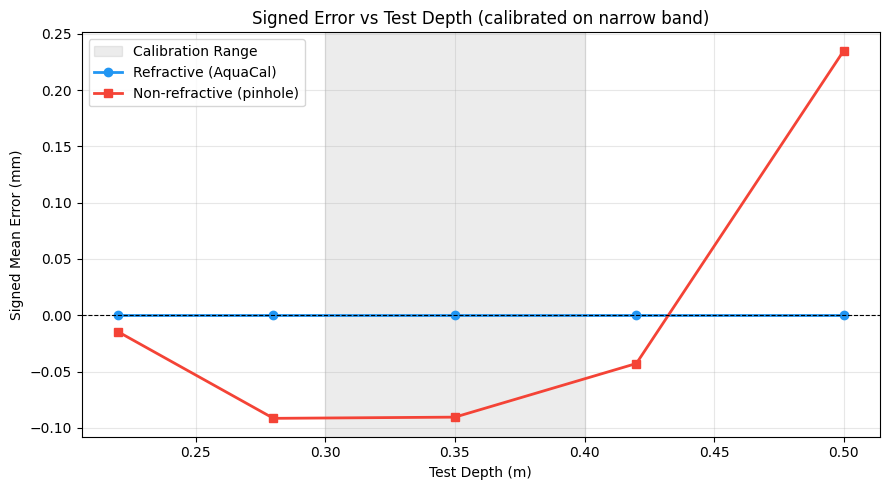

In [10]:
depths_plot = [r["depth"] for r in results_refr_exp2]
signed_refr = [r["signed_mean_mm"] for r in results_refr_exp2]
signed_nonrefr = [r["signed_mean_mm"] for r in results_nonrefr_exp2]

fig, ax = plt.subplots(figsize=(9, 5))
ax.axvspan(EXP2_CALIB_RANGE[0], EXP2_CALIB_RANGE[1], alpha=0.15, color="gray", label="Calibration Range")
ax.plot(depths_plot, signed_refr, marker="o", color=COLOR_REFRACTIVE, label=LABEL_REFRACTIVE, linewidth=2)
ax.plot(depths_plot, signed_nonrefr, marker="s", color=COLOR_NON_REFRACTIVE, label=LABEL_NON_REFRACTIVE, linewidth=2)
ax.axhline(0, color="black", linewidth=0.8, linestyle="--")
ax.set_xlabel("Test Depth (m)")
ax.set_ylabel("Signed Mean Error (mm)")
ax.set_title("Signed Error vs Test Depth (calibrated on narrow band)")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

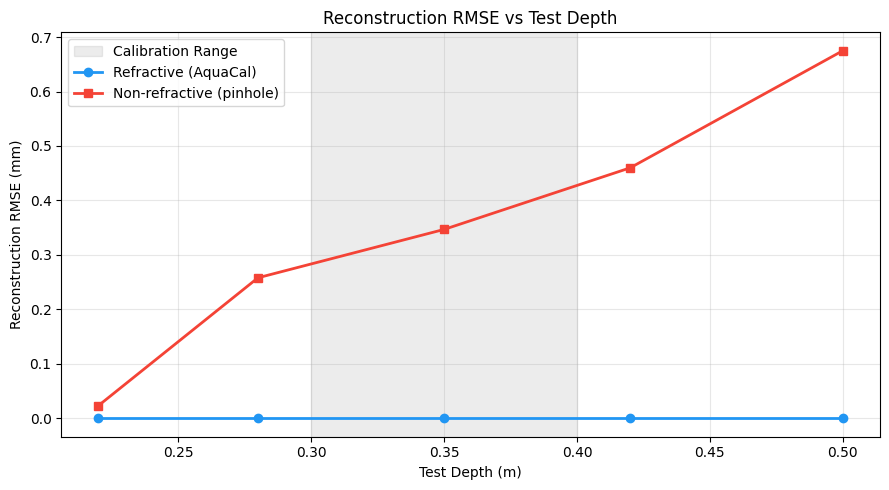

Maximum RMSE across all test depths:
  Refractive:     0.00 mm
  Non-refractive: 0.67 mm


In [11]:
rmse_refr = [r["rmse_mm"] for r in results_refr_exp2]
rmse_nonrefr = [r["rmse_mm"] for r in results_nonrefr_exp2]

fig, ax = plt.subplots(figsize=(9, 5))
ax.axvspan(EXP2_CALIB_RANGE[0], EXP2_CALIB_RANGE[1], alpha=0.15, color="gray", label="Calibration Range")
ax.plot(depths_plot, rmse_refr, marker="o", color=COLOR_REFRACTIVE, label=LABEL_REFRACTIVE, linewidth=2)
ax.plot(depths_plot, rmse_nonrefr, marker="s", color=COLOR_NON_REFRACTIVE, label=LABEL_NON_REFRACTIVE, linewidth=2)
ax.set_xlabel("Test Depth (m)")
ax.set_ylabel("Reconstruction RMSE (mm)")
ax.set_title("Reconstruction RMSE vs Test Depth")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

max_rmse_refr = max(rmse_refr)
max_rmse_nonrefr = max(rmse_nonrefr)
print(f"Maximum RMSE across all test depths:")
print(f"  Refractive:     {max_rmse_refr:.2f} mm")
print(f"  Non-refractive: {max_rmse_nonrefr:.2f} mm")

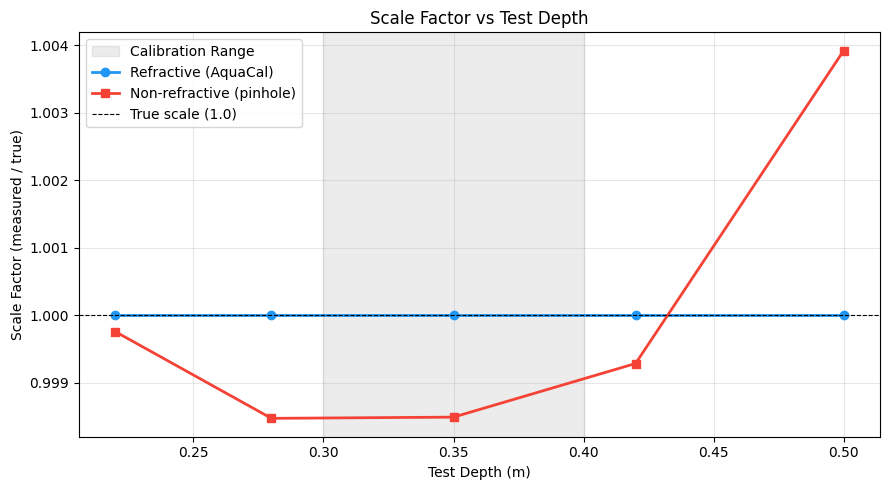

In [12]:
scale_refr = [r["scale"] for r in results_refr_exp2]
scale_nonrefr = [r["scale"] for r in results_nonrefr_exp2]

fig, ax = plt.subplots(figsize=(9, 5))
ax.axvspan(EXP2_CALIB_RANGE[0], EXP2_CALIB_RANGE[1], alpha=0.15, color="gray", label="Calibration Range")
ax.plot(depths_plot, scale_refr, marker="o", color=COLOR_REFRACTIVE, label=LABEL_REFRACTIVE, linewidth=2)
ax.plot(depths_plot, scale_nonrefr, marker="s", color=COLOR_NON_REFRACTIVE, label=LABEL_NON_REFRACTIVE, linewidth=2)
ax.axhline(1.0, color="black", linewidth=0.8, linestyle="--", label="True scale (1.0)")
ax.set_xlabel("Test Depth (m)")
ax.set_ylabel("Scale Factor (measured / true)")
ax.set_title("Scale Factor vs Test Depth")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

### Experiment 2 Takeaway

The refractive model's error stays low across all test depths — it learned the actual
geometry and can generalize. The non-refractive model's error grows as we move away
from the calibration depth, because refraction angle changes with depth and the wrong
model can't adapt without re-calibrating.

This is particularly important for applications where the measurement depth varies:
animal tracking, reef surveys, or any scenario where targets move in depth.

---
## Experiment 3: Depth Scaling

**Question:** Even if we calibrate at exactly the depth where we measure,
does non-refractive error increase at greater depths?

This is a tougher test for the non-refractive model: we give it the "best case"
scenario — a fresh calibration at each target depth. If refraction were a
constant offset, the model could compensate by adjusting parameters. But refraction
is depth-dependent and the compensation worsens as the geometry changes.

We repeat the calibrate-then-evaluate cycle at each depth in a sweep.

In [13]:
print("=== Experiment 3: Depth Scaling ===")
print(f"Sweep depths: {EXP3_SWEEP_DEPTHS}")

# Build rig (same geometry as Exp2 for consistency)
if RIG_SIZE == "small":
    intrinsics_exp3 = intrinsics_exp2
    extrinsics_exp3 = extrinsics_exp2
    water_zs_exp3 = water_zs_exp2
    board_config_exp3 = board_config_exp2
    noise_std_exp3 = 0.0
    n_grid_exp3 = 4
    xy_extent_exp3 = 0.05
    tilt_deg_exp3 = 2.0
else:
    intrinsics_exp3, extrinsics_exp3, water_zs_exp3 = generate_real_rig_array(
        height_above_water=0.75, height_variation=0.002, seed=42
    )
    board_config_exp3 = BoardConfig(
        squares_x=12, squares_y=9,
        square_size=0.060, marker_size=0.045,
        dictionary="DICT_5X5_100",
    )
    noise_std_exp3 = 0.5
    n_grid_exp3 = 7
    xy_extent_exp3 = 0.5
    tilt_deg_exp3 = 3.0

board_exp3 = BoardGeometry(board_config_exp3)

results_refr_exp3 = []
results_nonrefr_exp3 = []

for depth_idx, depth in enumerate(EXP3_SWEEP_DEPTHS):
    depth_seed = 42 + depth_idx * 100
    print(f"  Depth {depth:.2f} m:")

    # Calibrate at this depth (depth +/- 0.05m for small, +/- 0.1m for large)
    half_band = 0.05 if RIG_SIZE == "small" else 0.1
    calib_range = (max(0.01, depth - half_band), depth + half_band)

    if RIG_SIZE == "small":
        from aquacal.datasets.synthetic import generate_board_trajectory
        camera_positions_exp3 = {cam: ext.C for cam, ext in extrinsics_exp3.items()}
        calib_poses = generate_board_trajectory(
            n_frames=EXP3_N_CALIB_FRAMES,
            camera_positions=camera_positions_exp3,
            water_zs=water_zs_exp3,
            depth_range=calib_range,
            xy_extent=xy_extent_exp3,
            seed=42,
        )
    else:
        calib_poses = generate_real_rig_trajectory(
            n_frames=EXP3_N_CALIB_FRAMES,
            depth_range=calib_range,
            seed=42,
        )

    calib_scenario = SyntheticScenario(
        name=f"exp3_depth_{depth:.2f}",
        board_config=board_config_exp3,
        intrinsics=intrinsics_exp3,
        extrinsics=extrinsics_exp3,
        water_zs=water_zs_exp3,
        board_poses=calib_poses,
        noise_std=noise_std_exp3,
        description=f"Calibration at {depth:.2f} m",
    )

    print("    Calibrating refractive model...")
    result_refr = calibrate_synthetic(calib_scenario, n_water=1.333, refine_intrinsics=True)[0]
    per_cam_refr = compute_per_camera_errors(result_refr, calib_scenario)

    print("    Calibrating non-refractive model...")
    result_nonrefr = calibrate_synthetic(calib_scenario, n_water=1.0, refine_intrinsics=True)[0]
    per_cam_nonrefr = compute_per_camera_errors(result_nonrefr, calib_scenario)

    # Evaluate reconstruction at same depth
    test_poses = generate_dense_xy_grid(
        depth=depth,
        n_grid=n_grid_exp3,
        xy_extent=xy_extent_exp3,
        tilt_deg=tilt_deg_exp3,
        frame_offset=1000,
        seed=depth_seed + 1,
    )
    test_detections = generate_synthetic_detections(
        intrinsics=intrinsics_exp3,
        extrinsics=extrinsics_exp3,
        water_zs=water_zs_exp3,
        board=board_exp3,
        board_poses=test_poses,
        noise_std=noise_std_exp3,
        seed=depth_seed + 2,
    )

    dist_refr = evaluate_reconstruction(result_refr, board_exp3, test_detections)
    dist_nonrefr = evaluate_reconstruction(result_nonrefr, board_exp3, test_detections)

    focal_err_refr = np.mean([abs(e["focal_length_error_pct"]) for e in per_cam_refr.values()])
    focal_err_nonrefr = np.mean([abs(e["focal_length_error_pct"]) for e in per_cam_nonrefr.values()])

    results_refr_exp3.append({"depth": depth, "rmse_mm": dist_refr.rmse * 1000, "focal_err_pct": focal_err_refr})
    results_nonrefr_exp3.append({"depth": depth, "rmse_mm": dist_nonrefr.rmse * 1000, "focal_err_pct": focal_err_nonrefr})

print("\nDepth scaling sweep complete.")

=== Experiment 3: Depth Scaling ===
Sweep depths: [0.22, 0.3, 0.4, 0.5]
  Depth 0.22 m:
    Calibrating refractive model...


Stage 2: Extrinsic initialization...
Stage 3: Joint refractive optimization...


Stage 4: Intrinsic refinement...
    Calibrating non-refractive model...


Stage 2: Extrinsic initialization...
Stage 3: Joint refractive optimization...


Stage 4: Intrinsic refinement...


C:\Users\tucke\PycharmProjects\AquaCal\src\aquacal\validation\reconstruction.py:268: UserWarning: No valid 3D distance comparisons - returning NaN
  warnings.warn("No valid 3D distance comparisons - returning NaN")


  Depth 0.30 m:
    Calibrating refractive model...
Stage 2: Extrinsic initialization...
Stage 3: Joint refractive optimization...


Stage 4: Intrinsic refinement...


    Calibrating non-refractive model...
Stage 2: Extrinsic initialization...
Stage 3: Joint refractive optimization...


Stage 4: Intrinsic refinement...


  Depth 0.40 m:
    Calibrating refractive model...
Stage 2: Extrinsic initialization...
Stage 3: Joint refractive optimization...


Stage 4: Intrinsic refinement...


    Calibrating non-refractive model...
Stage 2: Extrinsic initialization...
Stage 3: Joint refractive optimization...


Stage 4: Intrinsic refinement...


  Depth 0.50 m:
    Calibrating refractive model...
Stage 2: Extrinsic initialization...


Stage 3: Joint refractive optimization...


Stage 4: Intrinsic refinement...


    Calibrating non-refractive model...
Stage 2: Extrinsic initialization...


Stage 3: Joint refractive optimization...


Stage 4: Intrinsic refinement...



Depth scaling sweep complete.


### Reconstruction RMSE vs Depth

Each point represents a fresh calibration at that exact depth — the non-refractive
model gets the best possible advantage. Yet its error still grows with depth because
the fundamental geometry is wrong: deeper targets have greater refraction angles,
and the compensation needed changes in a way the pinhole model cannot capture.

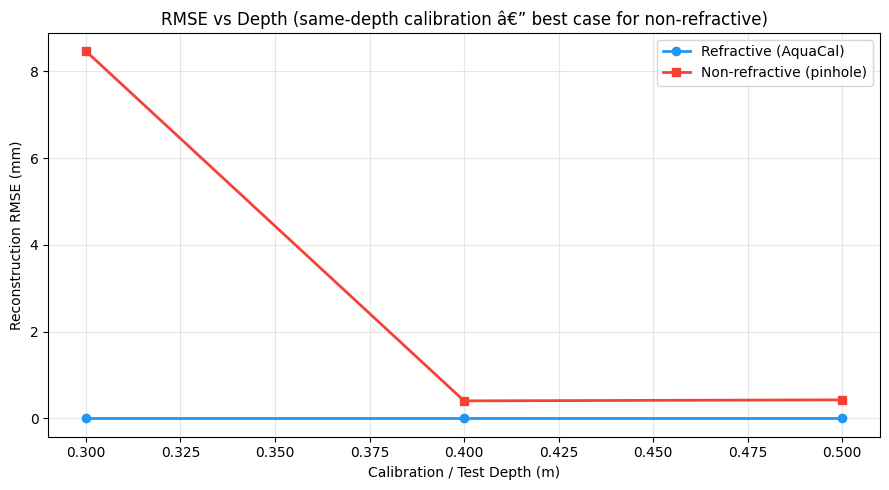

RMSE at shallowest (0.22 m):
  Refractive:     nan mm
  Non-refractive: nan mm
RMSE at deepest (0.50 m):
  Refractive:     0.00 mm
  Non-refractive: 0.43 mm


In [14]:
depths_exp3 = [r["depth"] for r in results_refr_exp3]
rmse_refr_exp3 = [r["rmse_mm"] for r in results_refr_exp3]
rmse_nonrefr_exp3 = [r["rmse_mm"] for r in results_nonrefr_exp3]

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(depths_exp3, rmse_refr_exp3, marker="o", color=COLOR_REFRACTIVE, label=LABEL_REFRACTIVE, linewidth=2)
ax.plot(depths_exp3, rmse_nonrefr_exp3, marker="s", color=COLOR_NON_REFRACTIVE, label=LABEL_NON_REFRACTIVE, linewidth=2)
ax.set_xlabel("Calibration / Test Depth (m)")
ax.set_ylabel("Reconstruction RMSE (mm)")
ax.set_title("RMSE vs Depth (same-depth calibration — best case for non-refractive)")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

print(f"RMSE at shallowest ({depths_exp3[0]:.2f} m):")
print(f"  Refractive:     {rmse_refr_exp3[0]:.2f} mm")
print(f"  Non-refractive: {rmse_nonrefr_exp3[0]:.2f} mm")
print(f"RMSE at deepest ({depths_exp3[-1]:.2f} m):")
print(f"  Refractive:     {rmse_refr_exp3[-1]:.2f} mm")
print(f"  Non-refractive: {rmse_nonrefr_exp3[-1]:.2f} mm")

### Focal Length Error vs Depth

As target depth increases, the required focal length compensation changes.
The non-refractive model must use a different "wrong" focal length at each depth
to minimize reprojection error, revealing how the model absorbs the depth-dependent
refraction effect into an intrinsic parameter.

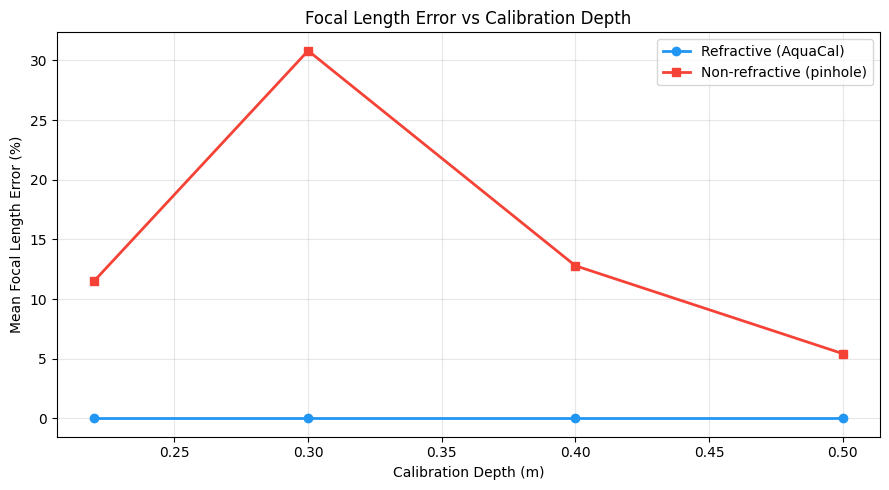

In [15]:
focal_refr_exp3 = [r["focal_err_pct"] for r in results_refr_exp3]
focal_nonrefr_exp3 = [r["focal_err_pct"] for r in results_nonrefr_exp3]

fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(depths_exp3, focal_refr_exp3, marker="o", color=COLOR_REFRACTIVE, label=LABEL_REFRACTIVE, linewidth=2)
ax.plot(depths_exp3, focal_nonrefr_exp3, marker="s", color=COLOR_NON_REFRACTIVE, label=LABEL_NON_REFRACTIVE, linewidth=2)
ax.set_xlabel("Calibration Depth (m)")
ax.set_ylabel("Mean Focal Length Error (%)")
ax.set_title("Focal Length Error vs Calibration Depth")
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()
plt.close()

### Experiment 3 Takeaway

Even with same-depth calibration (the best case for the non-refractive model),
its reconstruction error grows with depth. The fundamental geometry is wrong:
deeper targets bend through a greater refraction angle, requiring a larger
compensation, but the pinhole model can't represent refraction-dependent distortion.

This means you can't "fix" a non-refractive calibration for deep work by calibrating
at the right depth — the model is structurally incapable of capturing the effect.

---
## Summary

Three experiments, one conclusion: **refraction is not a nuisance to be calibrated away;
it is a physical constraint that must be modeled explicitly.**

| Experiment | What we tested | Key finding |
|------------|---------------|-------------|
| 1 — Parameter Fidelity | Same data, two models | Non-refractive absorbs refraction into focal length and position bias |
| 2 — Depth Generalization | Calibrate narrow, test wide | Non-refractive error grows away from calibration depth |
| 3 — Depth Scaling | Same-depth calibration at each depth | Non-refractive error still grows with depth |

**When is refractive calibration essential?**
- Camera-to-water distance is significant (≥ 0.3 m)
- Measurement depth varies across sessions or within a session
- High 3D accuracy is required (< 5 mm)
- You need stable calibration across depth ranges

**When might pinhole be acceptable?**
- Cameras are very close to the water surface (< 0.1 m)
- Only 2D detection or tracking is needed (no 3D reconstruction)
- Accuracy requirements are very relaxed (> 20 mm)
- Data collection depth is constant and pre-known

---

**Further reading:**
- [Full pipeline tutorial](01_full_pipeline.ipynb) — calibrate a rig end-to-end
- [Theory documentation](../guide/theory.md) — mathematical derivation of the refractive model
- [Optimizer guide](../guide/optimizer.md) — tuning the Stage 3 bundle adjustment